<a href="https://colab.research.google.com/github/kwanderer/MachineLearning/blob/main/RF_Klasifikacija_IRS_multiklass_one_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Laika virknēm (*Time series*) datu sadala gabalos - apakšvirknēs. Līdzīgi kā k-pārklājumu gadījumā;
*   K-Pārklājumiem:
  * Jo lielāks K, jo objektīvāks modelis, bet lielāka variance starp dažādiem modeļiem;
  * Jo mazāks K, jo lielāka iespēja iegūt vairākus vājus modeļus;
* Nejauša izlase jāveic bez aizvietošanas. Aizvietošana ir nejauša izlase no apmācības kopas, kurā **var dublēties ieraksti**
* Nejauša izlase ar aizvietošanu ir *bootstrap* sāknētājs: 
    Mazina kļūdas ietekmes novērtējumu - tas ir optimistiskāks;

## Datu iegūšana

In [13]:
from sklearn import linear_model  #pip install sklearn - loti plasa masinapmacibas biblioteka
from sklearn.linear_model import LinearRegression  
import csv          #pip install csv - darbam ar CSV datu kopam
import requests     #pip install requests  - vienkarsakam darbam ar tiessaistes CSV datu kopam tiessaistes
import numpy as np  #pip inall numpy - darbam ar masiviem un skaitliskiem datiem
import pandas as pd #pip install pandas - darbam ar datu kopam

In [14]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/data_multiclass")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
df = pd.read_csv("combined_multiclass_csv.csv")

In [16]:
print(df.info())              # Pārliecināmies, ka kolonnas nesaturs tukšas vērtības

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000000 entries, 0 to 29999999
Data columns (total 9 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   tachometer                     float64
 1   und-accelerometer-axial        float64
 2   und-accelerometer-radial       float64
 3   und-accelerometer-tangential   float64
 4   over-accelerometer-axial       float64
 5   over-accelerometer-radial      float64
 6   over-accelerometer-tangential  float64
 7   microphone                     float64
 8   Class                          int64  
dtypes: float64(8), int64(1)
memory usage: 2.0 GB
None


In [17]:
df[df.columns] = df[df.columns].apply(pd.to_numeric)  # Visas l\kolonnas pārvēršam par skaitliskiem tipiem, jo redzējām, ka tie ir skaitļi
print("\n", df.describe(include=['number']))          # Attēlojam kopas statistiku
print(df.info())                                      # vēlreiz izdrukājam kopsavilkumu par datu kopu un kvalitāti


          tachometer  und-accelerometer-axial  und-accelerometer-radial  \
count  3.000000e+07             3.000000e+07              3.000000e+07   
mean   1.414637e-04             1.315306e-02             -2.493558e-04   
std    1.646523e+00             1.004443e+00              4.971494e-01   
min   -1.425000e+00            -1.906400e+01             -7.292000e+00   
25%   -6.456600e-01            -7.622600e-01             -3.273000e-01   
50%   -5.953200e-01             1.350000e-01              1.287600e-02   
75%   -5.039000e-01             8.976500e-01              3.313300e-01   
max    5.114900e+00             2.165400e+00              3.193800e+00   

       und-accelerometer-tangential  over-accelerometer-axial  \
count                  3.000000e+07              3.000000e+07   
mean                   4.011626e-04              1.089396e-02   
std                    1.421448e-01              5.507483e-01   
min                   -7.551200e-01             -8.488600e+00   
25%   

In [18]:
# pārbaudam vai visas vērtības ir vienā vērtību skalā. 
print(df[:10].to_markdown()) 

|    |   tachometer |   und-accelerometer-axial |   und-accelerometer-radial |   und-accelerometer-tangential |   over-accelerometer-axial |   over-accelerometer-radial |   over-accelerometer-tangential |   microphone |   Class |
|---:|-------------:|--------------------------:|---------------------------:|-------------------------------:|---------------------------:|----------------------------:|--------------------------------:|-------------:|--------:|
|  0 |     -0.5964  |                  1.6569   |                   0.20359  |                      0.048174  |                   -0.18477 |                   -0.021301 |                        -0.18447 |   -0.017205  |       7 |
|  1 |     -0.52322 |                 -0.28902  |                  -0.3174   |                     -0.0014495 |                   -0.19779 |                   -0.023694 |                        -0.28712 |   -0.018203  |       7 |
|  2 |     -0.5532  |                  1.6477   |                   0.41715  |  

## Datu sagatavošana

Pirmais, kas darāms pēc datu iegūšanas un apskates, jāveic datu kopas sagatavošana

In [19]:
from sklearn.model_selection import train_test_split

training_frac = 0.7

# iegūstam klases, kas tiks klasificētas piemērā
Classes = df['Class'].unique()

# unikālās klases
print("Klašu vērtības", Classes,'\n')

#Klašu kodēšana
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['Class'])
print(le.classes_)

Klašu vērtības [7 6 5 4 3 2 1 0] 

[0 1 2 3 4 5 6 7]


In [20]:
# atlasām tikai faktoru kolonnas, klases kolonna nav vajadzīga
Sample = df[["tachometer", "und-accelerometer-axial", "und-accelerometer-radial", "und-accelerometer-tangential", "over-accelerometer-axial", "over-accelerometer-radial", "over-accelerometer-tangential", "microphone"]].to_numpy()

#atlasām klases kolonnu
y = le.transform(df['Class'])
print(y)

# tiek veikta datu kopas sadalīšana testa un apmācības kopā, izmantojot nejaušu sadalījumu ar attecību 70 : 30
X_train, X_test, y_train, y_test = train_test_split(Sample, y, test_size=1.0 - training_frac, random_state=42)

print('Done .........')

[7 7 7 ... 0 0 0]
Done .........


## Klasifikācijas koka izveide

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

# izveidojam koka instanci
clf = DecisionTreeClassifier(random_state=0)

#veicam koka apmācību
clf = clf.fit(X_train, y_train)

#pamata datu izvade par koku
print("Leaves: " + str(clf.get_n_leaves()))
print("Tree depth: " + str(clf.get_depth()))
print("Done......")

Leaves: 349
Tree depth: 20
Done......


### Klasifikācijas koka attēlošana

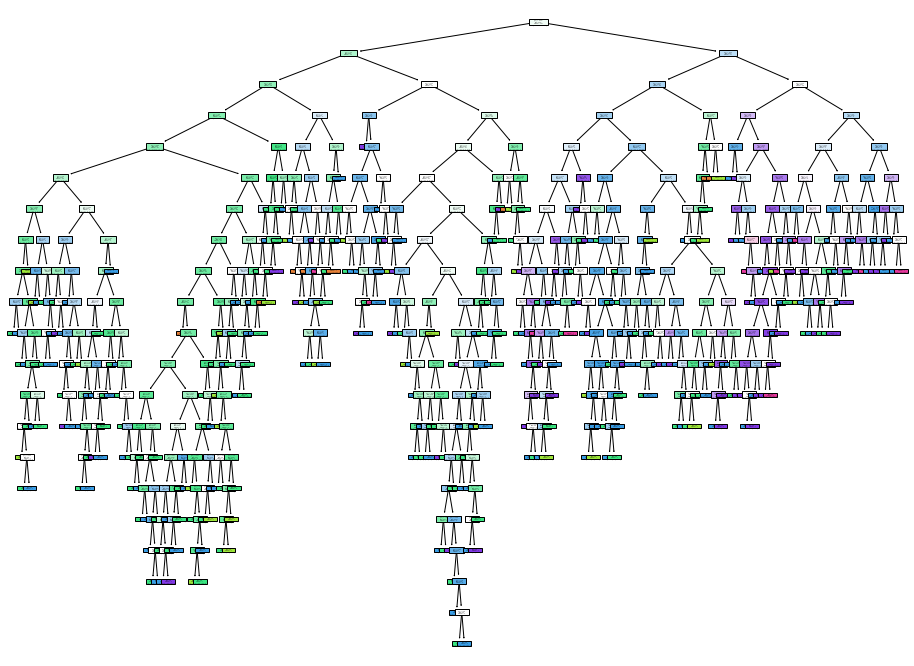

In [ ]:
import matplotlib.pyplot as plt

#Izveidojam jaunu attālu ar norādīto izmēru
plt.figure(figsize = (16,12))
#Izveidojam koka vizualizāciju
tree.plot_tree(clf, filled = True) 

plt.show()

### Klasifikatora izmantošana

In [ ]:
clf.predict(X_test)

array([2, 2, 3, 3, 3, 2, 2, 3, 2, 3, 4, 2, 2, 3, 2, 5, 2, 3, 3, 2, 2, 3,
       2, 4, 2, 3, 4, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 1, 5, 1, 3, 2, 2,
       3, 2, 4, 4, 2, 3, 2, 2, 3, 4, 2, 2, 3, 2, 3, 2, 2, 4, 3, 2, 4, 3,
       3, 2, 3, 3, 4, 0, 3, 3, 3, 2, 2, 2, 4, 4, 2, 4, 2, 3, 3, 3, 2, 3,
       4, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 4, 3, 2, 3, 3,
       4, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 2, 1, 3, 3,
       2, 3, 3, 2, 2, 3, 3, 2, 4, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2,
       3, 2, 2, 4, 3, 3, 2, 3, 4, 2, 3, 3, 3, 2, 2, 2, 2, 2, 4, 2, 4, 2,
       3, 2, 4, 2, 2, 2, 2, 4, 2, 3, 3, 2, 5, 2, 3, 3, 3, 4, 3, 2, 2, 3,
       3, 4, 2, 3, 2, 3, 4, 3, 2, 3, 3, 4, 5, 2, 2, 3, 5, 3, 3, 3, 3, 2,
       3, 3, 5, 2, 2, 2, 3, 4, 3, 2, 2, 2, 4, 2, 2, 4, 2, 3, 3, 2, 3, 1,
       4, 4, 2, 4, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 4, 2, 4,
       3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 4, 3, 3, 2, 2, 2, 2, 4,
       2, 2, 2, 3, 3, 3, 0, 4, 2, 4, 1, 4, 3, 3, 2,

In [ ]:
clf.predict(X_test[[7]])

array([3])

In [ ]:
print(X_test[[7]])

[[ 2.      0.9956 10.      0.78    7.      0.08  ]]


In [ ]:
clf.feature_importances_

array([0.1232246 , 0.13511894, 0.22628913, 0.19148347, 0.19652354,
       0.12736032])

## Koka nocirpšana

Number of nodes in the last tree is: 3 with ccp_alpha: 0.06588291907778787


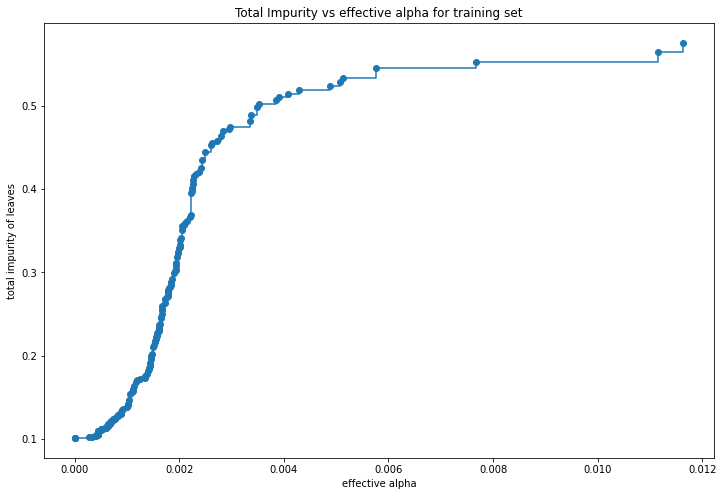

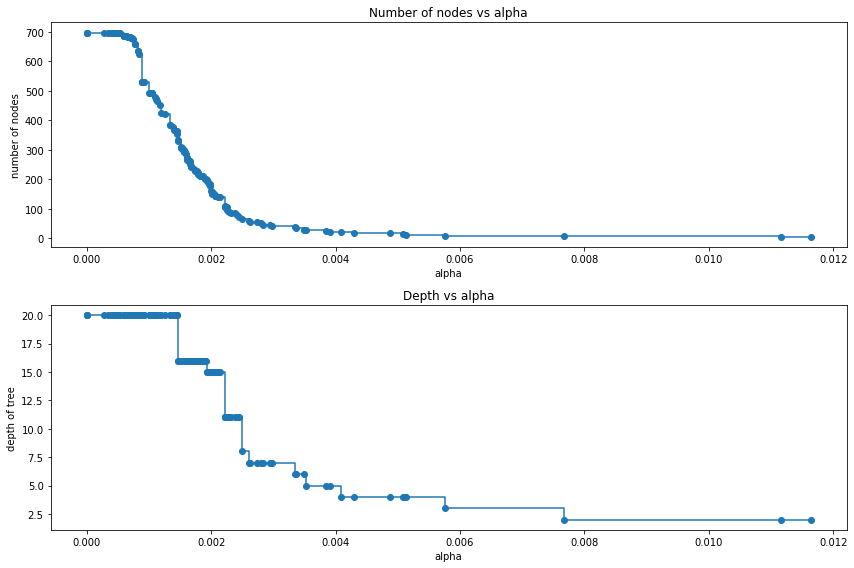

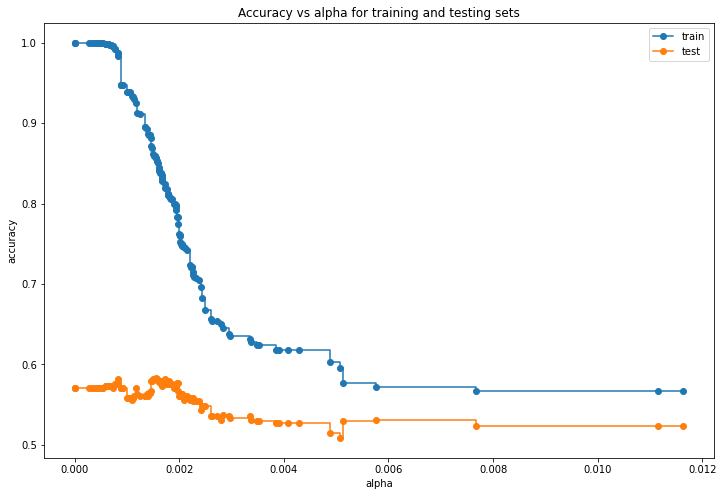

Done......


In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
clf = DecisionTreeClassifier(random_state=0, max_depth=30, min_samples_split = 2, min_samples_leaf = 2)

#Calculation of impurity
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))


clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize = (12,8))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Done......")

## "Apcirpta" koka ģenerēšana

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

# izveidojam koka instanci
clf = DecisionTreeClassifier(random_state=0,  ccp_alpha=0.004)

#veicam koka apmācību
clf = clf.fit(X_train, y_train)

#pamata datu izvade par koku
print("Leaves: " + str(clf.get_n_leaves()))
print("Tree depth: " + str(clf.get_depth()))
print("Done......")

Leaves: 12
Tree depth: 5
Done......


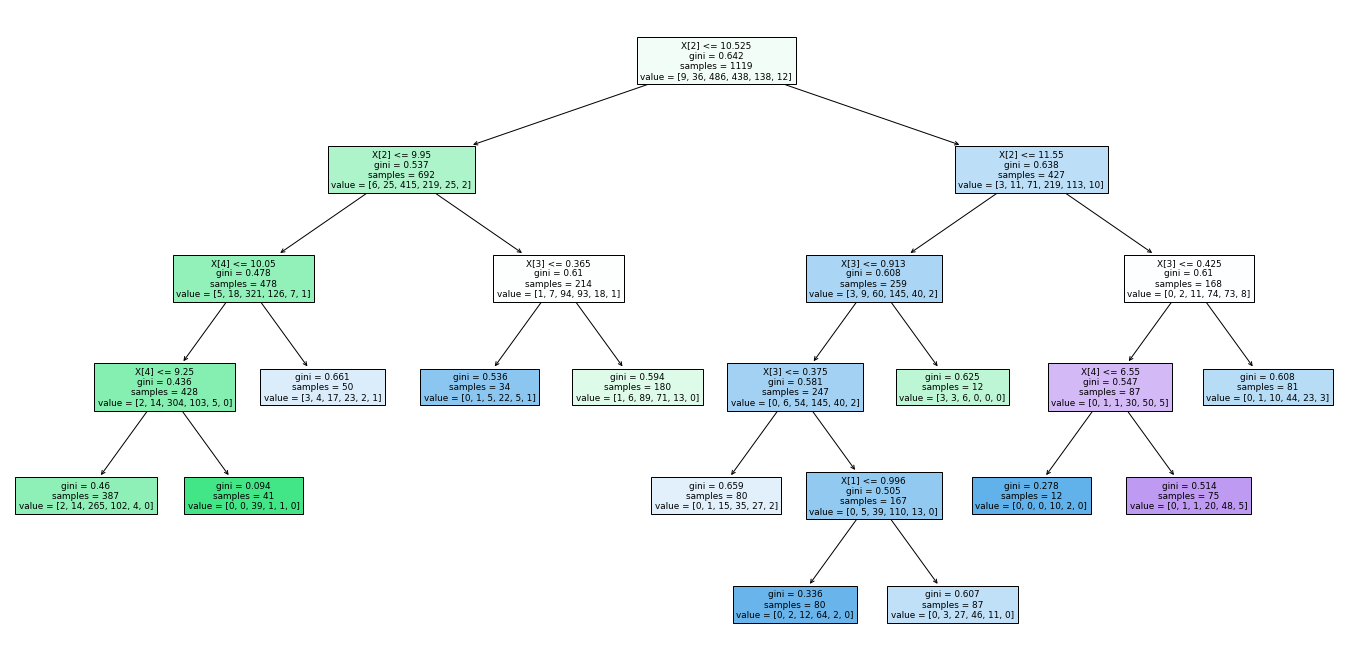

In [ ]:
import matplotlib.pyplot as plt

#Izveidojam jaunu attālu ar norādīto izmēru
plt.figure(figsize = (24,12))
#Izveidojam koka vizualizāciju
tree.plot_tree(clf, filled = True) 

plt.show()

#['residual sugar', 'density', 'alcohol', 'volatile acidity','fixed acidity','citric acid']

## Rezultātu interpretēšana

In [ ]:
print(y_test, y_pred)

[3 2 3 2 3 2 2 2 2 3 4 0 2 2 3 4 2 4 5 2 2 3 2 3 3 3 4 3 2 3 2 2 3 2 3 2 4
 2 1 3 2 2 4 2 2 3 4 3 2 3 2 2 2 4 3 3 3 2 2 2 2 4 2 3 3 2 3 2 3 2 3 1 3 3
 3 2 5 2 3 3 2 3 2 3 3 4 2 3 4 1 4 3 2 2 2 3 2 3 2 3 2 2 2 4 3 4 3 2 3 2 5
 2 3 2 3 4 3 3 2 3 3 3 3 3 3 3 4 3 2 2 3 2 2 2 3 2 2 2 2 3 4 3 5 2 2 2 3 3
 3 2 3 4 3 2 3 2 2 3 3 3 4 2 4 2 2 2 3 3 2 2 3 2 4 3 4 3 3 2 2 3 1 3 2 4 2
 2 1 2 4 3 2 3 3 4 3 2 2 3 2 4 2 3 3 2 4 2 2 2 3 4 4 2 2 3 3 4 3 2 3 3 3 3
 3 4 1 2 2 4 2 2 2 2 3 3 2 4 2 3 3 3 2 1 3 4 3 4 2 3 3 2 2 3 2 3 1 2 3 3 2
 3 3 2 2 3 4 4 3 2 3 3 2 3 2 3 2 2 2 3 3 3 4 2 2 3 2 4 2 3 1 3 3 5 3 2 2 3
 2 4 3 3 2 2 4 3 3 2 3 3 2 4 3 3 3 3 2 3 2 2 3 1 3 3 3 2 2 2 3 3 3 3 1 4 3
 3 3 2 3 4 2 2 3 4 2 2 3 2 3 2 3 2 2 3 2 3 3 3 2 3 1 2 1 2 2 3 2 3 3 2 2 2
 2 2 3 2 3 3 3 2 2 3 2 2 3 3 3 4 3 2 2 3 3 2 2 3 4 3 2 3 2 4 2 2 4 2 3 4 4
 3 3 2 3 3 4 3 2 4 3 3 3 2 2 2 2 2 3 2 2 2 4 3 4 3 1 2 4 2 2 2 3 3 3 3 3 2
 3 2 3 2 3 3 4 1 3 2 3 3 4 2 4 2 2 3 2 2 3 2 3 2 2 3 3 1 2 3 2 4 5 3 4 1] [2 2 3 2 3 2 2 2 2 3 3 2 2

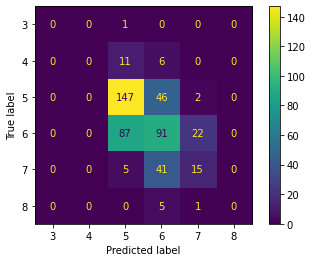

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm,display_labels=le.classes_).plot()

### Dažādas formālas metrikas

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print("Kopējā vidējā precizitāte :                         ",accuracy_score(y_test, y_pred))

#F1 metrika: F1 = 2 * (precision * sensitivity) / (precision + sensitivity)
# 1 - vislabākais gadījums, 0 - vissliktākais

print("Kopējā vidējā F1 vērtība pa visām klasēm :           ",f1_score(y_test, y_pred, average='macro'))
print("Kopējā vidējā F1 vērtība ņemot vērā klašu balansu : ",f1_score(y_test, y_pred, average='weighted'))

Kopējā vidējā precizitāte :                          0.5270833333333333
Kopējā vidējā F1 vērtība pa visām klasēm :            0.2373481419983099
Kopējā vidējā F1 vērtība ņemot vērā klašu balansu :  0.5004889115823752


## *Random Forest* modeļa izveide

In [21]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=10)          # Izveidojam klasifikatoru ar 10 kokiem un maks. dziļumu 5
rf.fit(X_train, y_train)                                                             # Modeļa apmācība

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=10)

Faktoru rangi:
4. faktors over-accelerometer-axial (0.523134)
5. faktors over-accelerometer-radial (0.149794)
6. faktors over-accelerometer-tangential (0.142916)
3. faktors und-accelerometer-tangential (0.105259)
2. faktors und-accelerometer-radial (0.066764)
1. faktors und-accelerometer-axial (0.009514)
7. faktors microphone (0.001562)
0. faktors tachometer (0.001057)


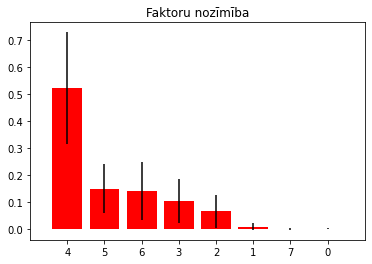

In [22]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_         # iegūstam faktoru nozīmības rādītājus
indices = np.argsort(importances)[::-1]       # iegūstam faktoru indeksus (kārtas numurus)
                                              # Definējam faktoruu nosaukums skaistākai izvadei
FeatureNames = ["tachometer", "und-accelerometer-axial", "und-accelerometer-radial", "und-accelerometer-tangential", "over-accelerometer-axial", "over-accelerometer-radial", "over-accelerometer-tangential", "microphone"]

#   Izvadam faktoru rangus
print("Faktoru rangi:")
for f in range(X_train.shape[1]):             # Katrā iterācijā apskatāmkonkrēta faktora rangu
                                              # Izvadām faktorus
    #print("%d. faktors %s (%f)" % (f + 1, FeatureNames[indices[f]], importances[indices[f]]))
    print("%d. faktors %s (%f)" % (indices[f], FeatureNames[indices[f]], importances[indices[f]]))

# Aprēķinām faktoru nozīmības standartnovirzes izvadei
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Izveidojam attēlu
plt.figure()
plt.title("Faktoru nozīmība")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Konkrēta koka izvade

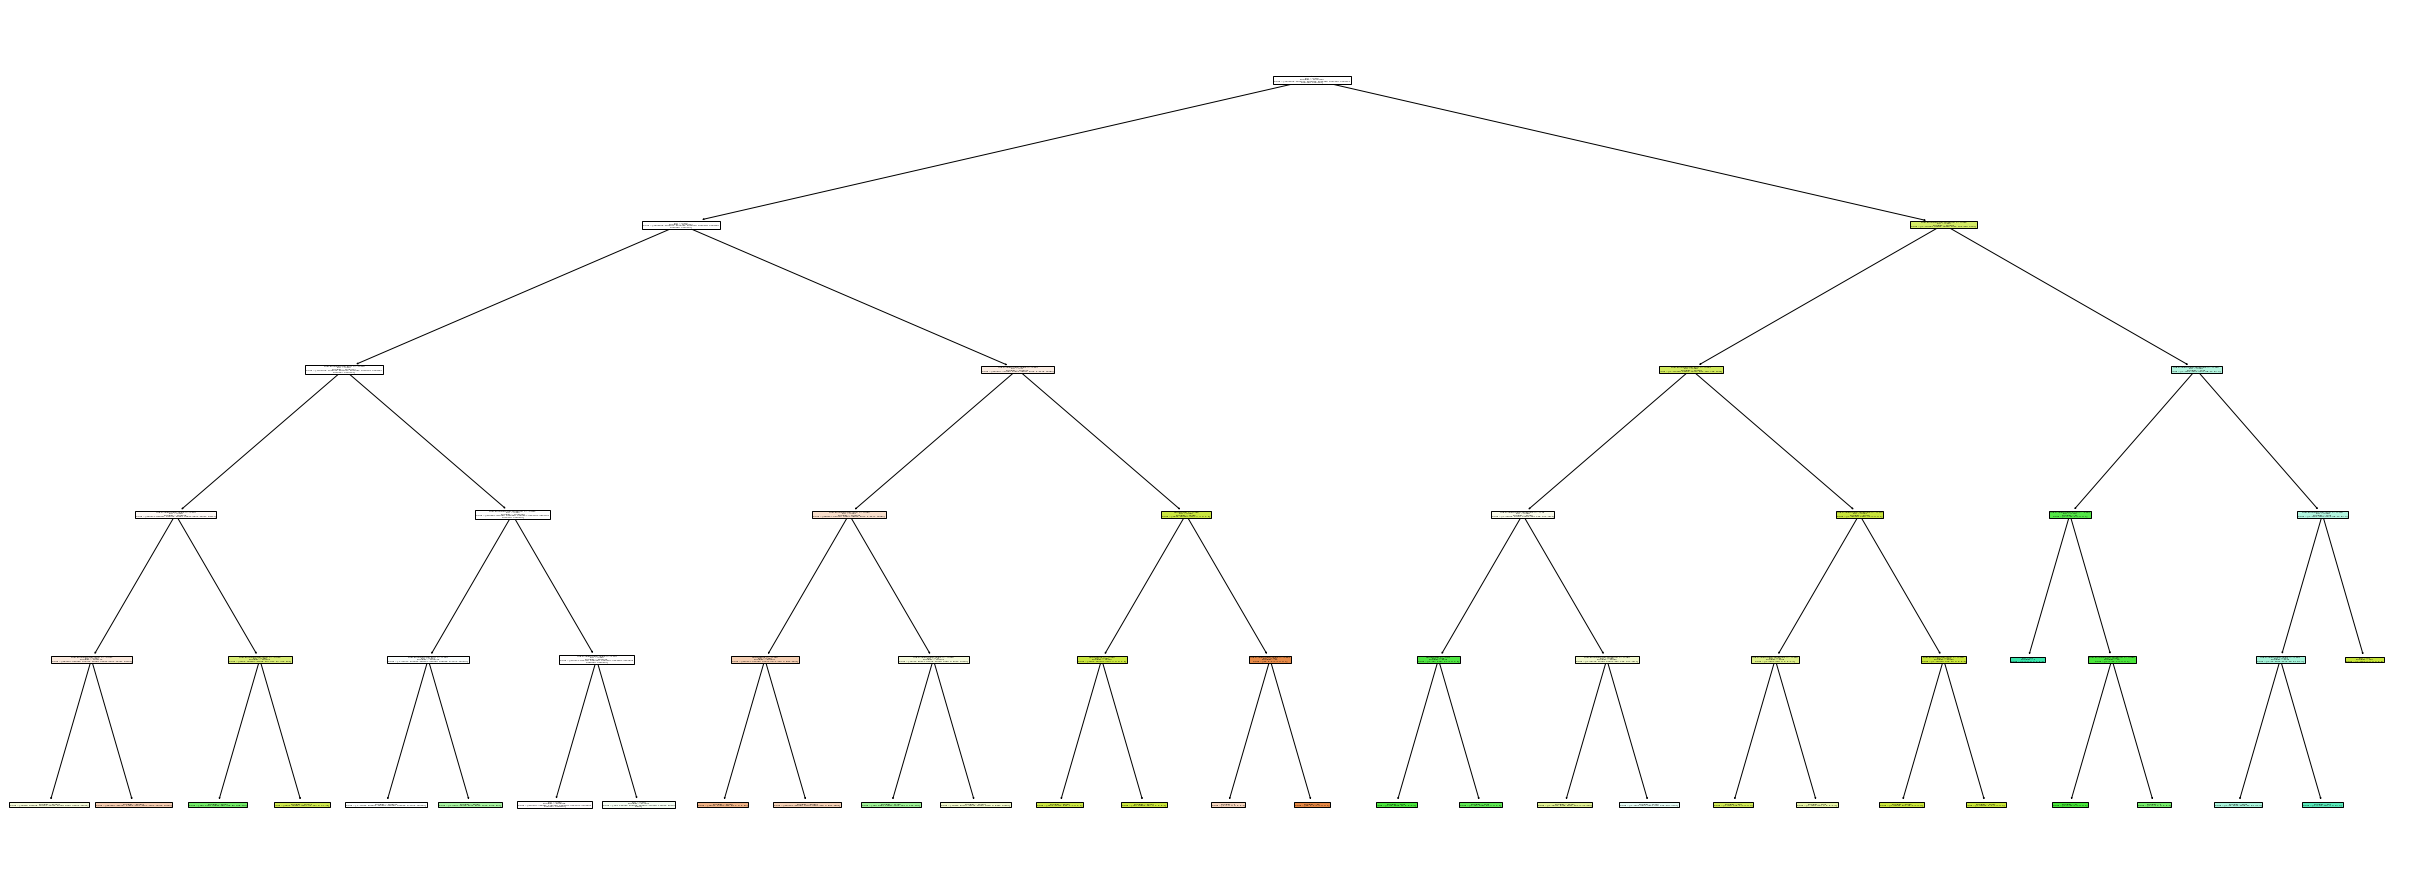

In [25]:
# Output of a single tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

# Pull out one tree from the forest
treeclassifier = rf.estimators_[2]


import matplotlib.pyplot as plt

plt.figure(figsize = (43,16))

tree.plot_tree(treeclassifier, filled = True, feature_names=FeatureNames) 

plt.show()

### Rezultātu interpretēšana

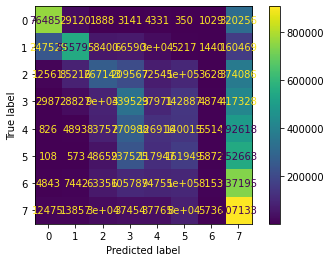

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm,display_labels=le.classes_).plot()

### Dažādas formālas metrikas

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print("Kopējā vidējā precizitāte :                         ",accuracy_score(y_test, y_pred))

#F1 metrika: F1 = 2 * (precision * sensitivity) / (precision + sensitivity)
# 1 - vislabākais gadījums, 0 - vissliktākais

print("Kopējā vidējā F1 vērtība pa visām klasēm :           ",f1_score(y_test, y_pred, average='macro'))
print("Kopējā vidējā F1 vērtība ņemot vērā klašu balansu : ",f1_score(y_test, y_pred, average='weighted'))

Kopējā vidējā precizitāte :                          0.3479400724511031
Kopējā vidējā F1 vērtība pa visām klasēm :            0.3230379540372337
Kopējā vidējā F1 vērtība ņemot vērā klašu balansu :  0.32304724774229604
